In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tensorflow as tf

from tensorflow_hmm import hmm

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [4]:
P = np.array([[0.9, 0.1], [0.1, 0.9]])
P = P**1
P = P / np.sum(P,1)
print('P', P)
hmm_tf = hmm.HMMTensorflow(P, np.array([0.0, 1.0]))

P [[ 0.9  0.1]
 [ 0.1  0.9]]


/home/ros/data/IPython/tensorflow_hmm/tensorflow_hmm/hmm.py:40: RuntimeWarning: divide by zero encountered in log
  self.logp0 = np.log(self.p0)


In [5]:
# observations = np.array([0, 0.0, 1.0, 1.0])
# observations = np.array([0.5] * 90)
# observations = np.random.random(60)
# observations = np.zeros(90)
# observations = np.sin(np.arange(-10, 10, 20/90.))
# observations -= 0.2
# observations[62:] = 0.2
# observations += np.arange(-1, 1, 2 / 90.)
# observations += np.random.random(90) * 0.4 - 0.2

In [6]:
# truth is off for 60 steps, then on for 30 time steps
truth = np.array([[1, 0]]*60 + [[0, 1]]*30, dtype=float)
truth = np.expand_dims(truth, axis=0)

## Observations

Observations can be thought of as the probability of being in any given state at each time step. For this demonstration, observations are randomly initialized. In a real case, these observations would be the output of a neural network

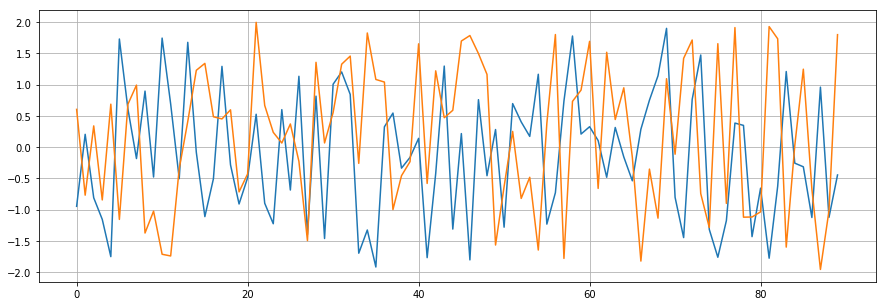

In [7]:
observations = np.random.random((1, 90, 2)) * 4 - 2

plot(observations[0,:,:])
grid()

In [8]:
observations_variable = tf.Variable(observations)

In [9]:
posterior_graph, _, _ = hmm_tf.forward_backward(tf.sigmoid(observations_variable))

In [10]:
# build error function
sum_error_squared = tf.reduce_sum(tf.square(truth - posterior_graph))

In [11]:
# calculate d_observation/d_error
gradients_graph = tf.gradients(sum_error_squared, observations_variable)

In [12]:
session = tf.Session()
session.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [13]:
steps = 0

## Posterior vs Truth

The posterior is the probability assigned by the hmm of being in each state at each time step.

This is a plot if the posterior output compared to the truth.

In [14]:
posterior = session.run(posterior_graph)

sum error squared: 0.611


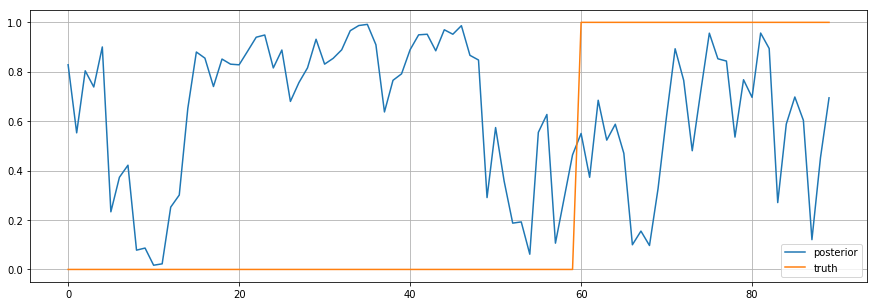

In [15]:
print('sum error squared: %.03f' % sum((truth[:,1] - posterior[:,1])**2))
plot(posterior[0,:,1], label='posterior')
plot(truth[0,:,1], label='truth')
grid()
legend()

## Gradients

This plot shows the gradients which are flowing back to the input of the hmm. 

In [16]:
gradients = session.run(gradients_graph)[0]

In [17]:
def plot_gradients(gradients):
    gradients = gradients[0]

    # whiten gradients
    gradients = gradients / np.std(gradients)

    plot(-gradients[:,1], label='gradients')
    plot(truth[0,:,1], label='truth')
    # plot(sigmoid(observations[0,:,1]), label='observations')
    plot(observations[0,:,1], label='observations')
    ylim((-5,5))
    grid()
    legend()

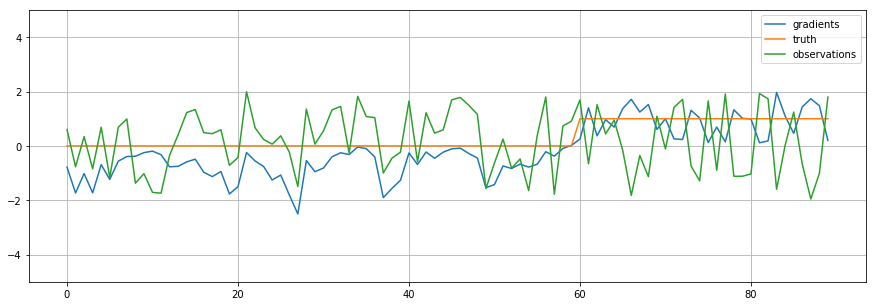

In [18]:
plot_gradients(gradients)

In [19]:
for i in range(1):
    # take 1 gradient descent step
    steps += 1
    observations = session.run(
        observations_variable.assign_sub(gradients * 0.5 * (random.random() - 0.25))
    )

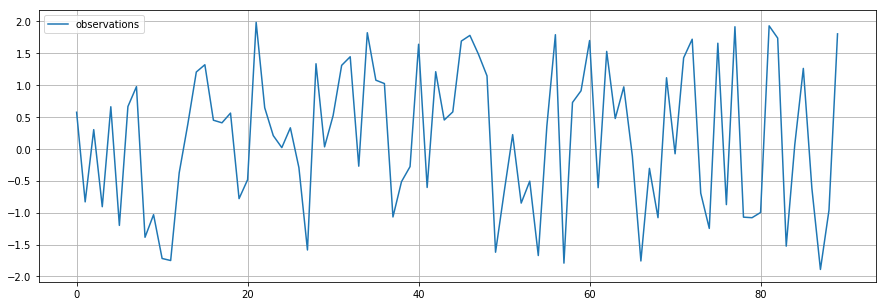

In [20]:
plot(observations[0,:,1], label='observations')
sigmoid = np.vectorize(lambda x: 1.0/(1.0+np.exp(-x)))
# plot(sigmoid(observations[0,:,1]), label='sigmoid(observations)')
legend()
grid()

gradient steps taken: 1
viterbi error: 50.0


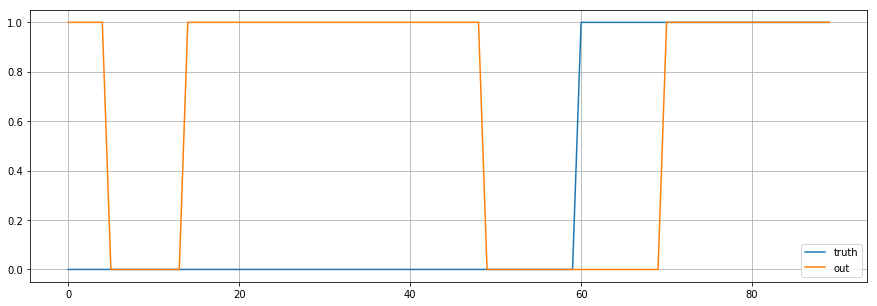

In [21]:
hmm_np = hmm.HMMNumpy(np.array([[0.9, 0.1], [0.1, 0.9]]), p0=np.array([0.5, 0.5]))

out, _ = hmm_np.viterbi_decode(sigmoid(observations[0,:,:]))

print('gradient steps taken:', steps)
print ('viterbi error:', sum((truth[0,:,1] - out)**2))
plot(truth[0,:,1], label='truth')
plot(out, label='out')
grid()
legend()